# **Text Classification**

Importing all the necessary libraries to be used in the project:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, SpatialDropout1D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

**1. Loading the dataset:**

Getting the dataset from kaggle:

In [3]:
!mkdir p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis
License(s): ODbL-1.0
100% 6.38M/6.38M [00:01<00:00, 7.79MB/s]
100% 6.38M/6.38M [00:01<00:00, 4.88MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/amazon-kindle-book-review-for-sentiment-analysis.zip','r')
zip_ref.extractall('/content/')
zip_ref.close()

Reading the dataset:

In [6]:
#reading the dataset using pandas
df = pd.read_csv("/content/preprocessed_kindle_review .csv")
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


**2. Data understanding, analysis and cleaning:**

In [7]:
# Selecting required columns only i.e. reviews and ratings
df = df[["reviewText", "rating"]]
df.head()

,reviewText,rating
0,This book was the very first bookmobile book I...,5
1,"When I read the description for this book, I c...",1
2,I just had to edit this review. This book is a...,5
3,I don't normally buy 'mystery' novels because ...,5
4,"This isn't the kind of book I normally read, a...",5


In [8]:
# def categorize_rating(rating):
#     if rating >= 4:
#         return "Positive"
#     elif rating == 3:
#         return "Neutral"
#     else:
#         return "Negative"

# df["rating"] = df["rating"].apply(categorize_rating)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  12000 non-null  object
 1   rating      12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [10]:
df.describe()

,rating
count,12000.000000
mean,3.250000
std,1.421619
min,1.000000
25%,2.000000
50%,3.500000
75%,4.250000
max,5.000000


In [11]:
df['rating'].value_counts()

rating
5    3000
4    3000
1    2000
3    2000
2    2000
Name: count, dtype: int64

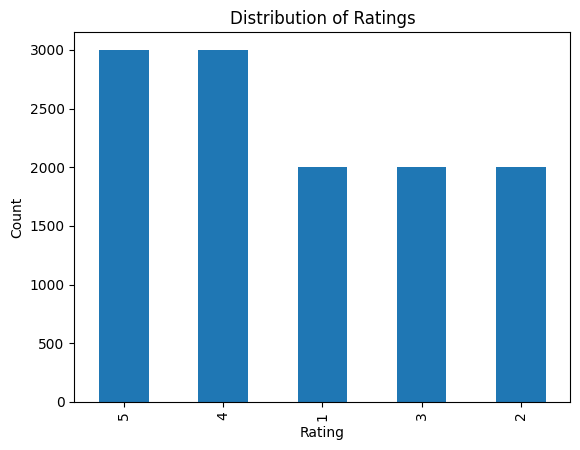

In [12]:
rating_counts = df['rating'].value_counts()

rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

**Data Cleaning and normalization:**

Changing all the data into lower case:

In [13]:
df['reviewText'] = df['reviewText'].str.lower()

In [14]:
df['reviewText'] = df['reviewText'].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

Finding out all the characters in the dataset to see if there are any odd
or unwanted characters:

In [15]:
chars = set()

for item in df["reviewText"]:
    chars = chars.union(item)

chars = sorted(chars)

print(chars)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


In [16]:
def clean_text(text):
    valid_chars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,*"
    cleaned_text = ''.join(char for char in text if char in valid_chars)
    return cleaned_text

df["reviewText"] = df["reviewText"].apply(clean_text)

In [17]:
df.head()

,reviewText,rating
0,book first bookmobile book bought school book ...,5
1,"read description book, wait read it. downloade...",1
2,edit review. book i believe got right updated ...,5
3,normally buy mystery novels like them. however...,5
4,"kind book normally read, although try limit ce...",5


**Tokenizations:**

**Lemmatization:**

In [18]:
def text_lemmatizer(text):
    tokens = nltk.word_tokenize(text)

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

In [19]:
df['reviewText'] = df['reviewText'].apply(text_lemmatizer)

In [20]:
df.head()

,reviewText,rating
0,book first bookmobile book bought school book ...,5
1,"read description book , wait read it . downloa...",1
2,edit review . book i believe got right updated...,5
3,normally buy mystery novel like them . however...,5
4,"kind book normally read , although try limit c...",5


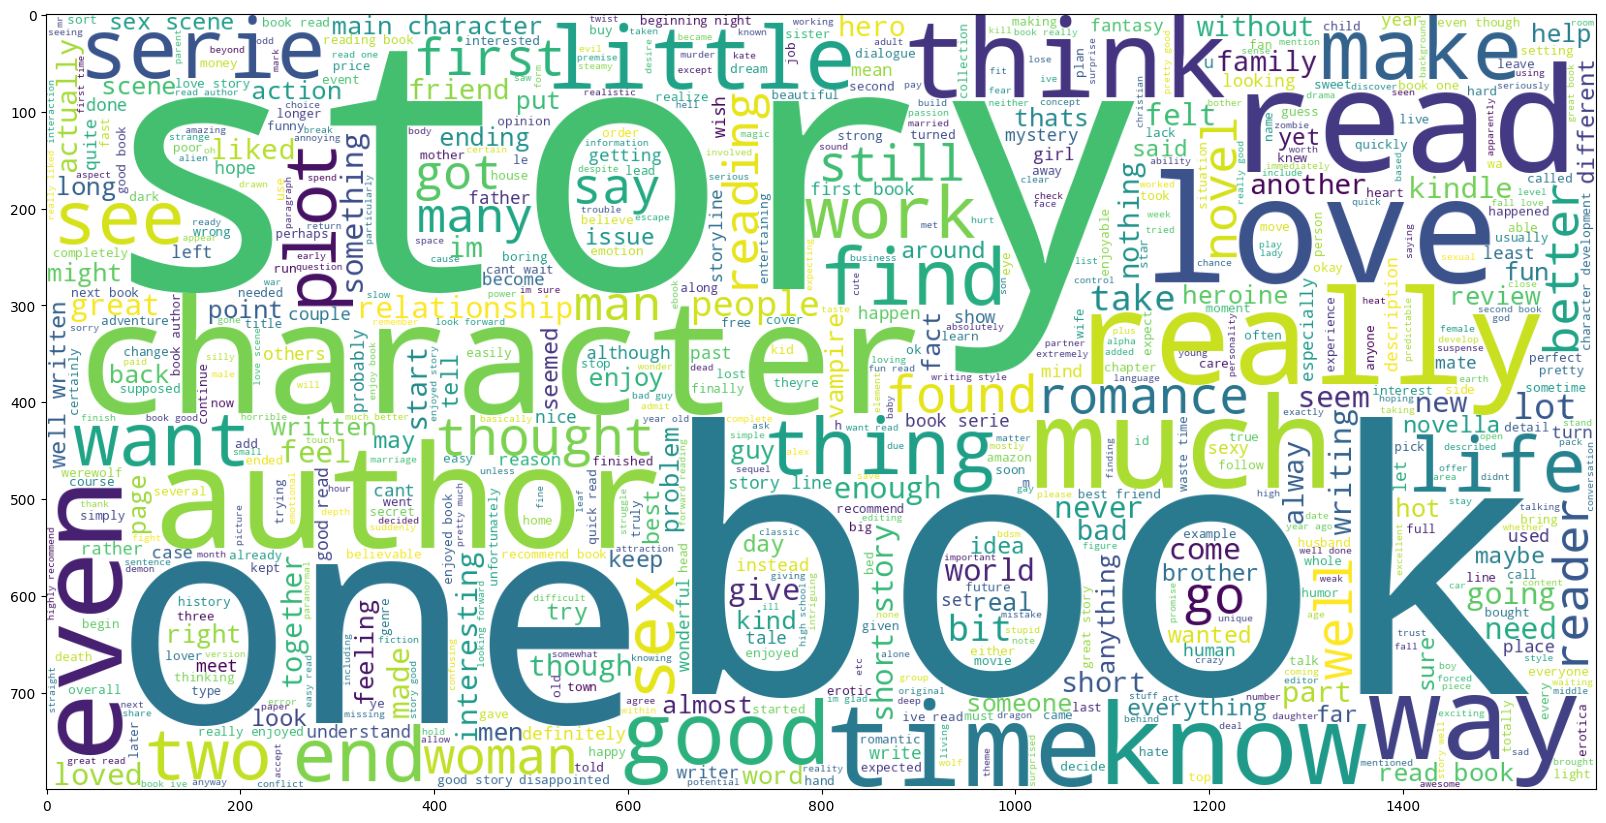

In [21]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600,
               background_color="white", colormap="viridis").generate(" ".join(df["reviewText"]))

plt.imshow(wc)

In [22]:
df['rating'] = df['rating'].apply(lambda rating: 2 if rating >= 4 else 1 if rating == 3 else 0)

In [23]:
df.head()

,reviewText,rating
0,book first bookmobile book bought school book ...,2
1,"read description book , wait read it . downloa...",0
2,edit review . book i believe got right updated...,2
3,normally buy mystery novel like them . however...,2
4,"kind book normally read , although try limit c...",2


In [24]:
token = Tokenizer()
token.fit_on_texts(df['reviewText'])

In [25]:
vocab_size = len(token.index_word)

In [26]:
vocab_size

33887

In [27]:
token.index_word

{1: 'book',
 2: 'story',
 3: 'read',
 4: 'one',
 5: 'character',
 6: 'like',
 7: 'good',
 8: 'would',
 9: 'really',
 10: 'love',
 11: 'time',
 12: 'get',
 13: 'it',
 14: 'author',
 15: 'series',
 16: 'reading',
 17: 'much',
 18: 'first',
 19: 'well',
 20: 'even',
 21: 'short',
 22: 'way',
 23: 'know',
 24: 'great',
 25: 'could',
 26: 'sex',
 27: 'make',
 28: 'little',
 29: 'thing',
 30: 'two',
 31: 'want',
 32: 'i',
 33: 'think',
 34: 'plot',
 35: 'also',
 36: 'find',
 37: 'romance',
 38: 'end',
 39: 'im',
 40: 'life',
 41: 'the',
 42: 'see',
 43: 'go',
 44: 'enjoyed',
 45: 'scene',
 46: 'never',
 47: 'me',
 48: 'take',
 49: 'woman',
 50: 'many',
 51: 'kindle',
 52: 'lot',
 53: 'written',
 54: 'say',
 55: 'work',
 56: 'thought',
 57: 'interesting',
 58: 'bit',
 59: 'found',
 60: 'going',
 61: 'year',
 62: 'give',
 63: 'writing',
 64: 'novel',
 65: 'loved',
 66: 'liked',
 67: 'another',
 68: 'better',
 69: 'got',
 70: 'feel',
 71: 'come',
 72: 'man',
 73: 'still',
 74: 'though',
 75: 'h

In [28]:
sequences = token.texts_to_sequences(df['reviewText'])
max_len = max([len(seq) for seq in sequences])
sequences_padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [29]:
sequences_padded

array([[    1,    18, 17285, ...,     0,     0,     0],
       [    3,   214,     1, ...,     0,     0,     0],
       [ 3151,    80,     1, ...,     0,     0,     0],
       ...,
       [  484,   783,    91, ...,     0,     0,     0],
       [  113,     2,    21, ...,     0,     0,     0],
       [33887,   541,   446, ...,     0,     0,     0]], dtype=int32)

In [30]:
df['rating'].unique()

array([2, 0, 1])

In [31]:
y = np.array(df['rating'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y, test_size=0.2, random_state=42)

In [33]:
import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [34]:
# Create an embedding matrix from the GloVe vectors
embedding_size = 100
embedding_matrix = np.zeros((vocab_size + 1, embedding_size))
for word, i in token.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_vectors[word] if word in glove_vectors else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [134]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_size, weights=[embedding_matrix], trainable=False, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(3, activation='softmax'))

In [135]:
from keras.optimizers import Adam

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1165, 100)         3388800   
                                                                 
 spatial_dropout1d_13 (Spat  (None, 1165, 100)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_26 (Bidirect  (None, 1165, 256)         234496    
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                     

In [136]:
# Train the model with early stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[early_stop])

Epoch 1/10
150/150 [==============================] - 60s 191ms/step - loss: 0.9959 - accuracy: 0.5876 - val_loss: 0.9164 - val_accuracy: 0.6271
Epoch 2/10
150/150 [==============================] - 27s 181ms/step - loss: 0.8991 - accuracy: 0.6329 - val_loss: 0.8552 - val_accuracy: 0.6571
Epoch 3/10
150/150 [==============================] - 27s 182ms/step - loss: 0.8644 - accuracy: 0.6430 - val_loss: 0.8305 - val_accuracy: 0.6692
Epoch 4/10
150/150 [==============================] - 27s 182ms/step - loss: 0.8238 - accuracy: 0.6634 - val_loss: 0.8013 - val_accuracy: 0.6825
Epoch 5/10
150/150 [==============================] - 27s 180ms/step - loss: 0.7896 - accuracy: 0.6812 - val_loss: 0.7657 - val_accuracy: 0.6975
Epoch 6/10
150/150 [==============================] - 27s 181ms/step - loss: 0.7827 - accuracy: 0.6821 - val_loss: 0.7665 - val_accuracy: 0.6892
Epoch 7/10
150/150 [==============================] - 27s 181ms/step - loss: 0.7474 - accuracy: 0.6993 - val_loss: 0.7363 - val_ac

<Axes: >

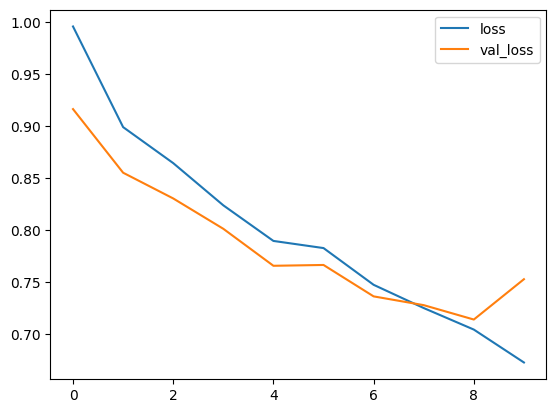

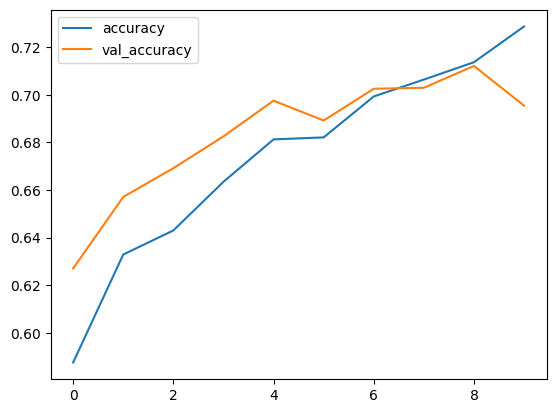

In [137]:
# Plot the training and validation curves
metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()

In [138]:
neg_review = ["Regrettably, I found this book to be a disappointment. Despite its promising premise, the execution fell short of delivering a compelling narrative. The writing lacked coherence, with ideas often feeling disjointed and underdeveloped. Additionally, the author's arguments seemed unconvincing, leaving me unconvinced of their validity. Overall, I cannot recommend this book, as it failed to meet even the most basic expectations."]
neg_review_token = token.texts_to_sequences(neg_review)
neg_review_padded = pad_sequences(neg_review_token, maxlen=max_len, padding='post', truncating='post')
review_predict = np.argmax(model.predict(neg_review_padded), axis=1)

1/1 [==============================] - 1s 1s/step


In [139]:
if review_predict[0] == 0:
    print("It's a negative review")
elif review_predict[0] == 1:
    print("It's a neutral review")
else:
    print("It's a positive review")

It's a negative review


In [140]:
pos_review = ["This book exceeded my expectations in every way. From the captivating narrative to the wealth of insights provided, each page held my attention effortlessly. The author's expertise shines through, offering a comprehensive and enlightening perspective on the subject matter. I found myself constantly engaged and eager to delve deeper into the content. I wholeheartedly recommend this book to anyone seeking a thought-provoking and enriching read."]
pos_review = token.texts_to_sequences(pos_review)
pos_review = pad_sequences(pos_review, maxlen=max_len, padding='post', truncating='post')
review_predict = np.argmax(model.predict(pos_review), axis=1)

1/1 [==============================] - 0s 67ms/step


In [141]:
if review_predict[0] == 0:
    print("It's a negative review")
elif review_predict[0] == 1:
    print("It's a neutral review")
else:
    print("It's a positive review")

It's a positive review


In [142]:
neutral_review = ["Upon reading this book, I found it to be an interesting exploration of its subject matter. The author presents their ideas in a clear and concise manner, making it accessible to readers of varying backgrounds. While some aspects were engaging, I felt that certain sections lacked depth, leaving me wanting more. Overall, it's a decent read for those interested in the topic."]
neutral_review_token = token.texts_to_sequences(neutral_review)
neutral_review_padded = pad_sequences(neutral_review_token, maxlen=max_len, padding='post', truncating='post')
review_predict = np.argmax(model.predict(neutral_review_padded), axis=1)

1/1 [==============================] - 0s 72ms/step


In [143]:
if review_predict[0] == 0:
    print("It's a negative review")
elif review_predict[0] == 1:
    print("It's a neutral review")
else:
    print("It's a positive review")

It's a positive review


In [144]:
prediction = np.argmax(model.predict(X_test), axis=1)
(classification_report(y_test, prediction))

75/75 [==============================] - 5s 70ms/step


'              precision    recall  f1-score   support\n\n           0       0.60      0.91      0.72       799\n           1       0.43      0.07      0.11       412\n           2       0.81      0.77      0.79      1189\n\n    accuracy                           0.70      2400\n   macro avg       0.61      0.58      0.54      2400\nweighted avg       0.68      0.70      0.65      2400\n'

In [145]:
# Function to plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [146]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

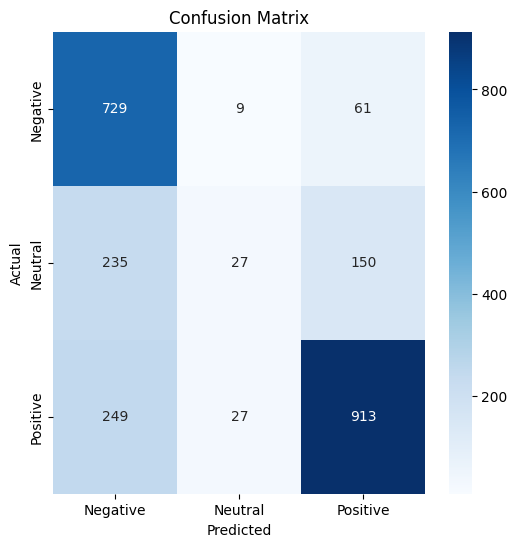

In [147]:
# Plot confusion matrix
labels = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(y_test, prediction, labels, 'Confusion Matrix')